Импроты и инициализация spark

In [1]:
from pyspark.conf import SparkConf
from pyspark.context import SparkContext
from pyspark.sql import SparkSession
import time
import pandas as pd
from pyspark.sql import SparkSession
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os

conf = SparkConf()
conf.setAppName('My spark')
conf.setMaster('local[*]')

sc=SparkContext.getOrCreate(conf=conf)
spark= SparkSession.builder.getOrCreate()

print(conf.toDebugString())

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


spark.app.name=My spark
spark.master=local[*]


In [20]:
path_to_file = 'PAMAP2_Dataset\Optional\subject101.dat'

activity_val_name = {
    1  : 'lying',
    2  : 'sitting',
    3  : 'standing',
    4  : 'walking',
    5  : 'running',
    6  : 'cycling',
    7  : 'Nordic walking',
    9  : 'watching TV',
    10 : 'computer work',
    11 : 'car driving',
    12 : 'ascending stairs',
    13 : 'descending stairs',
    16 : 'vacuum cleaning',
    17 : 'ironing',
    18 : 'folding laundry',
    19 : 'house cleaning',
    20 : 'playing soccer',
    24 : 'rope jumping',
    0  : 'other (transient activities)',
}

activity_name_val = {
    'lying' : 1 ,
    'sitting' : 2 ,
    'standing' : 3 ,
    'walking' : 4 ,
    'running' : 5 ,
    'cycling' : 6 ,
    'Nordic walking' : 7 ,
    'watching TV' : 9 ,
    'computer work' : 10,
    'car driving' : 11,
    'ascending stairs' : 12,
    'descending stairs' : 13,
    'vacuum cleaning' : 16,
    'ironing' : 17,
    'folding laundry' : 18,
    'house cleaning' : 19,
    'playing soccer' : 20,
    'rope jumping' : 24,
    'other (transient activities)' : 0 ,
}

col_names = ['Time_stamp', 'Activity_ID', 'Heart_Rate', 
              # Hand
             'Hand_temperature', 'Hand_3D_Acceleration_1', 'Hand_3D_Acceleration_2', 'Hand_3D_Acceleration_3',
             'Hand_3D_Acceleration_4', 'Hand_3D_Acceleration_5', 'Hand_3D_Acceleration_6', 'Hand_3D_Gyroscope_1',
             'Hand_3D_Gyroscope_2', 'Hand_3D_Gyroscope_3', 'Hand_3D_Magnetometer_1', 'Hand_3D_Magnetometer_2', 
             'Hand_3D_Magnetometer_3', 'Hand_3D_Orientation_1', 'Hand_3D_Orientation_2', 'Hand_3D_Orientation_3',
             'Hand_3D_Orientation_4',
             # Chest
             'Chest_temperature', 'Chest_3D_Acceleration_1', 'Chest_3D_Acceleration_2', 'Chest_3D_Acceleration_3',
             'Chest_3D_Acceleration_4', 'Chest_3D_Acceleration_5', 'Chest_3D_Acceleration_6', 'Chest_3D_Gyroscope_1',
             'Chest_3D_Gyroscope_2', 'Chest_3D_Gyroscope_3', 'Chest_3D_Magnetometer_1', 'Chest_3D_Magnetometer_2', 
             'Chest_3D_Magnetometer_3', 'Chest_3D_Orientation_1', 'Chest_3D_Orientation_2', 'Chest_3D_Orientation_3',
             'Chest_3D_Orientation_4',
             # Ankle
             'Ankle_temperature', 'Ankle_3D_Acceleration_1', 'Ankle_3D_Acceleration_2', 'Ankle_3D_Acceleration_3',
             'Ankle_3D_Acceleration_4', 'Ankle_3D_Acceleration_5', 'Ankle_3D_Acceleration_6', 'Ankle_3D_Gyroscope_1',
             'Ankle_3D_Gyroscope_2', 'Ankle_3D_Gyroscope_3', 'Ankle_3D_Magnetometer_1', 'Ankle_3D_Magnetometer_2', 
             'Ankle_3D_Magnetometer_3', 'Ankle_3D_Orientation_1','Ankle_3D_Orientation_2', 'Ankle_3D_Orientation_3',
             'Ankle_3D_Orientation_4']

from pyspark.sql.types import FloatType
from pyspark.sql.types import IntegerType
def load_df(path):
    
    df = spark.read.option('sep', ' ').csv(path)
    for i in range(len(df.columns)):
        df = df.withColumnRenamed('_c' + str(i), col_names[i])

    # Replace string on float
    for col_name in df.columns:
        df = df.withColumn(col_name, df[col_name].cast(FloatType()))
    df = df.withColumn('Activity_ID', df['Activity_ID'].cast(IntegerType()))
    
    # According to description, this values were measured incorrect
    df = df.drop(*['Ankle_3D_Orientation_1','Ankle_3D_Orientation_2', 'Ankle_3D_Orientation_3', 'Ankle_3D_Orientation_4'])
    df = df.drop(*['Chest_3D_Orientation_1', 'Chest_3D_Orientation_2', 'Chest_3D_Orientation_3', 'Chest_3D_Orientation_4'])
    df = df.drop(*['Hand_3D_Orientation_1', 'Hand_3D_Orientation_2', 'Hand_3D_Orientation_3', 'Hand_3D_Orientation_4'])

    
    return df

def shape(df):
    print((df.count(), len(df.columns)))
def unique(df, column):
     df.select(column).distinct().sort(column).show()
def getUnique(df, column, sort=False):
    if sort == True:
        return df.select(column).distinct().sort(column)
    else:
        return df.select(column).distinct()
def getList(df, column, limit=0):
    selected_df = df.select(column)
    if limit != 0:
        selected_df = selected_df.limit(limit)
    
    return [float(row[column]) for row in selected_df.collect()]

def print_available_activities(df, subject_id):
    activities = getList(getUnique(df, 'Activity_ID', True), 'Activity_ID')
    for i in range(len(activities)):
        activities[i] = int(activities[i])

    print('Activities ' + str(subject_id) + ':')
    for act in activities:
        print(activity_val_name[act])

def print_sensor_graphs(df, activity_name, sensor_names, data_limit=0, figsize=(10, 10)):
    df = df.filter(df.Activity_ID == activity_name_val[activity_name])
 
    if data_limit != 0:
        df = df.limit(data_limit)

    df = df.sort(df.Time_stamp)
    x = df.select(df.Time_stamp).collect()
    
    for sensor_name in sensor_names:
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(x, getList(df, sensor_name))
        ax.set_ylabel(sensor_name)
        ax.set_xlabel('Time')
        ax.set_title(activity_name)
        plt.grid(True)
        
def heart_rate_plot(df):
    fig, ax = plt.subplots(figsize=(20, 7))
    for i in activity_name_val:
        df_act = df.filter(df.Activity_ID == activity_name_val[i])
        df_act = df_act.sort(df_act.Time_stamp)
        x = df_act.select(df_act.Time_stamp).collect()
        ax.scatter(x, getList(df_act, 'Heart_Rate'), label=i)

    lgd = plt.legend(loc='best',fontsize = 9)
    ax.set_ylabel('Heart_Rate')
    ax.set_xlabel('Time')
    ax.set_title('Heart_Rate for different activities')
    plt.grid(True)
    
def hr_sensors_plot(df, activity_name, sensor_names, data_limit=0, figsize=(10, 10)):
    df = df.filter(df.Activity_ID == activity_name_val[activity_name])
 
    if data_limit != 0:
        df = df.limit(data_limit)

    df = df.sort(df.Heart_Rate)
    x = df.select(df.Heart_Rate).collect()
    
    fig, ax = plt.subplots(figsize=figsize)
    for sensor_name in sensor_names:
        ax.scatter(x, getList(df, sensor_name), label=sensor_name)
    lgd = plt.legend(loc='best',fontsize = 9)
    ax.set_ylabel('Sensors')
    ax.set_xlabel('Heart rate')
    ax.set_title(activity_name)
    plt.grid(True)

df_101 = load_df('PAMAP2_Dataset\Protocol\subject101.dat')
df_102 = load_df('PAMAP2_Dataset\Protocol\subject102.dat')
df_103 = load_df('PAMAP2_Dataset\Protocol\subject103.dat')
df_104 = load_df('PAMAP2_Dataset\Protocol\subject104.dat')
df_105 = load_df('PAMAP2_Dataset\Protocol\subject105.dat')
df_106 = load_df('PAMAP2_Dataset\Protocol\subject106.dat')
df_107 = load_df('PAMAP2_Dataset\Protocol\subject107.dat')
df_108 = load_df('PAMAP2_Dataset\Protocol\subject108.dat')
df_109 = load_df('PAMAP2_Dataset\Protocol\subject109.dat')


In [3]:
df_102.limit(3).show()
shape(df_102)
unique(df_102, 'Activity_ID')

+----------+-----------+----------+----------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+-------------------+-------------------+-------------------+----------------------+----------------------+----------------------+-----------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+--------------------+--------------------+--------------------+-----------------------+-----------------------+-----------------------+-----------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+--------------------+--------------------+--------------------+-----------------------+-----------------------+-----------------------+
|Time_stamp|Activity_ID|Heart_Rate|Hand_temperature|Hand_3D_Acceleration_1|Hand_3D_Acc

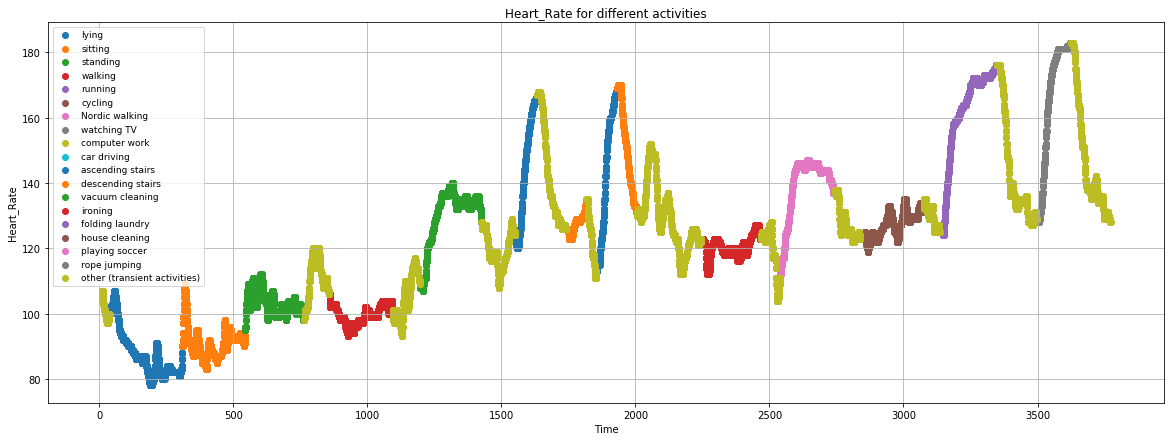

In [3]:
heart_rate_plot(df_101)

The plot show us the difference in the heart rate during various activity. All activities can be divided into 3 types: during which the pulse rises, decreases and fluctuates.

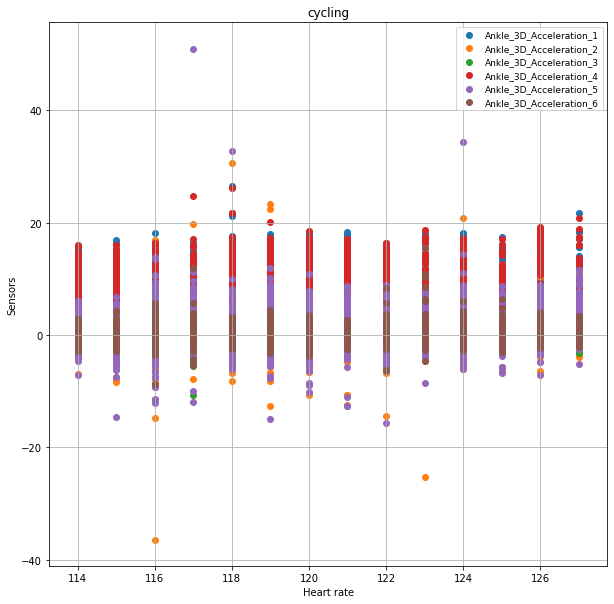

In [21]:
hr_sensors_plot(df_102, 'cycling', ['Ankle_3D_Acceleration_1', 'Ankle_3D_Acceleration_2', 'Ankle_3D_Acceleration_3', 'Ankle_3D_Acceleration_4', 'Ankle_3D_Acceleration_5', 'Ankle_3D_Acceleration_6'])

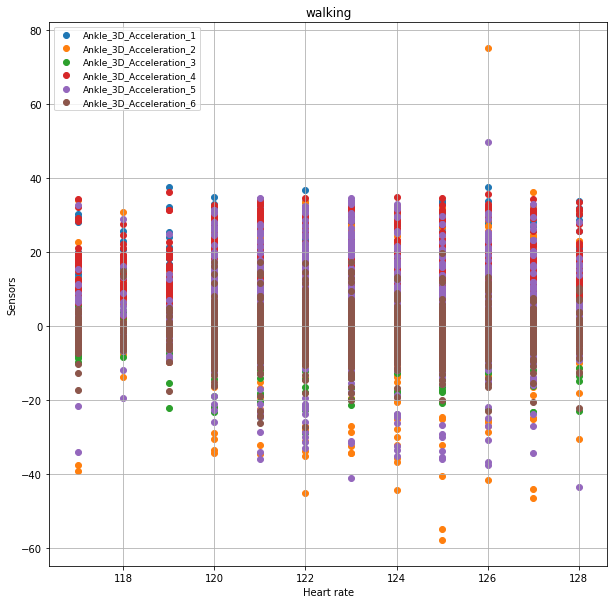

In [22]:
hr_sensors_plot(df_102, 'walking', ['Ankle_3D_Acceleration_1', 'Ankle_3D_Acceleration_2', 'Ankle_3D_Acceleration_3', 'Ankle_3D_Acceleration_4', 'Ankle_3D_Acceleration_5', 'Ankle_3D_Acceleration_6'])

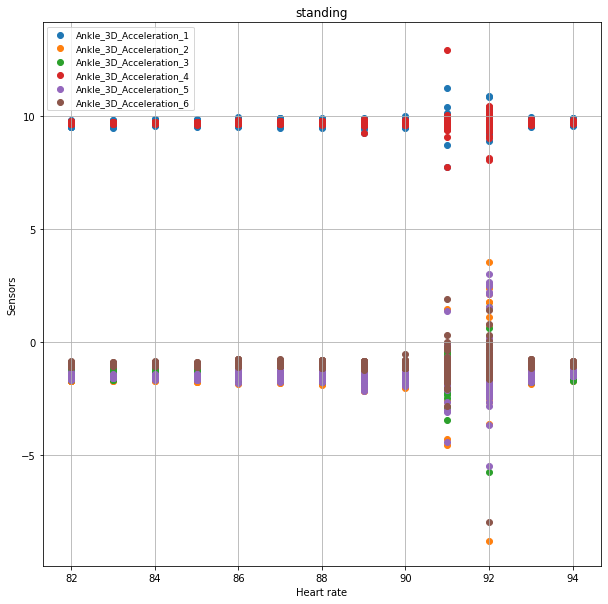

In [23]:
hr_sensors_plot(df_102, 'standing', ['Ankle_3D_Acceleration_1', 'Ankle_3D_Acceleration_2', 'Ankle_3D_Acceleration_3', 'Ankle_3D_Acceleration_4', 'Ankle_3D_Acceleration_5', 'Ankle_3D_Acceleration_6'])

The graphs show that with constant movement, the pulse increases gradually, but when the transition from a calm state to movement, the pulse increases sharply.

Activities 102:
other (transient activities)
lying
sitting
standing
walking
running
cycling
Nordic walking
ascending stairs
descending stairs
vacuum cleaning
ironing
rope jumping


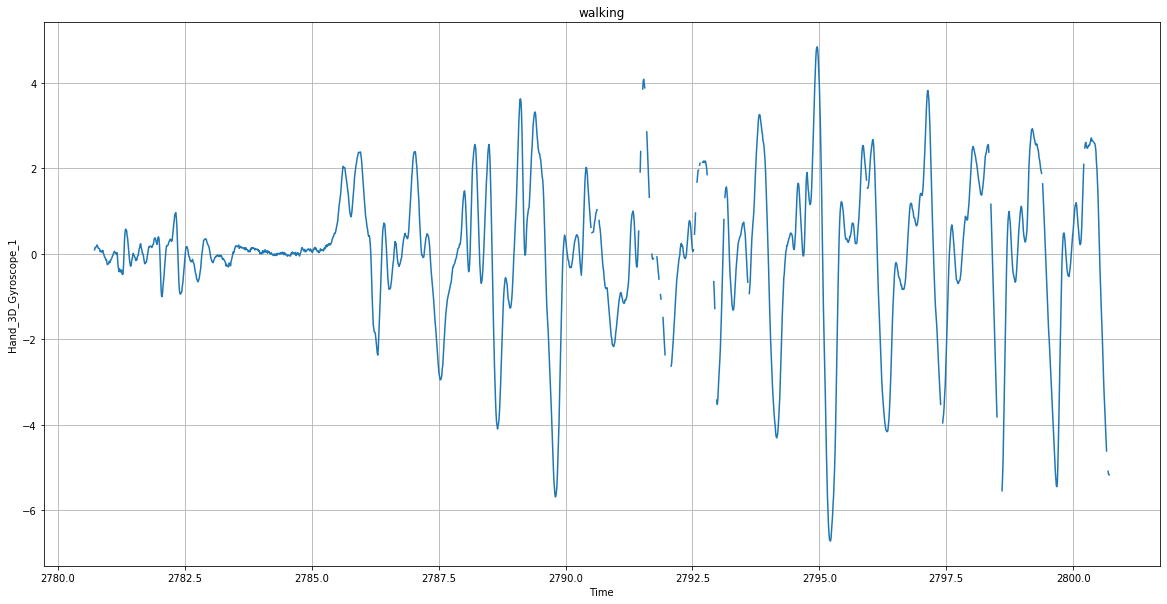

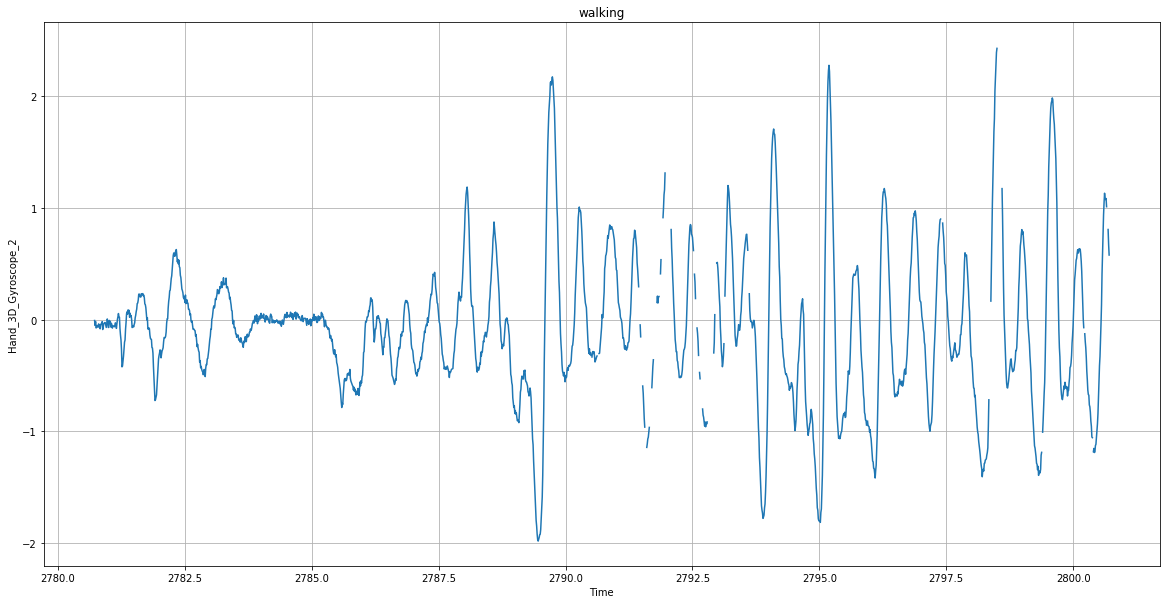

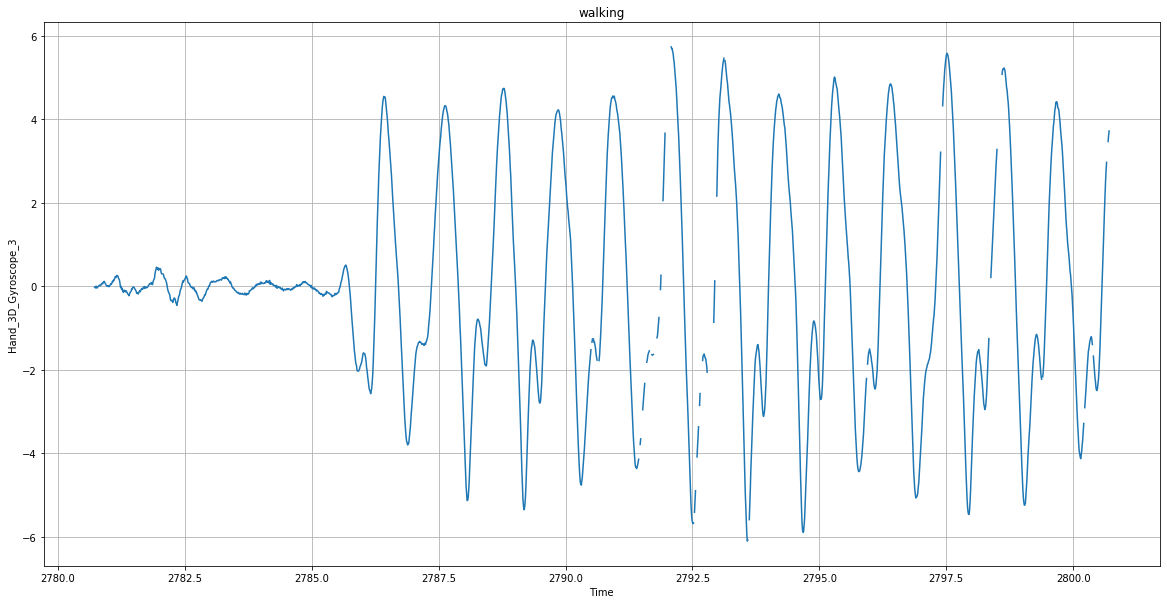

In [27]:
print_available_activities(df_102, 102)
print_sensor_graphs(df_102, 'walking', ['Hand_3D_Gyroscope_1', 'Hand_3D_Gyroscope_2', 'Hand_3D_Gyroscope_3'], 2000, (20, 10))

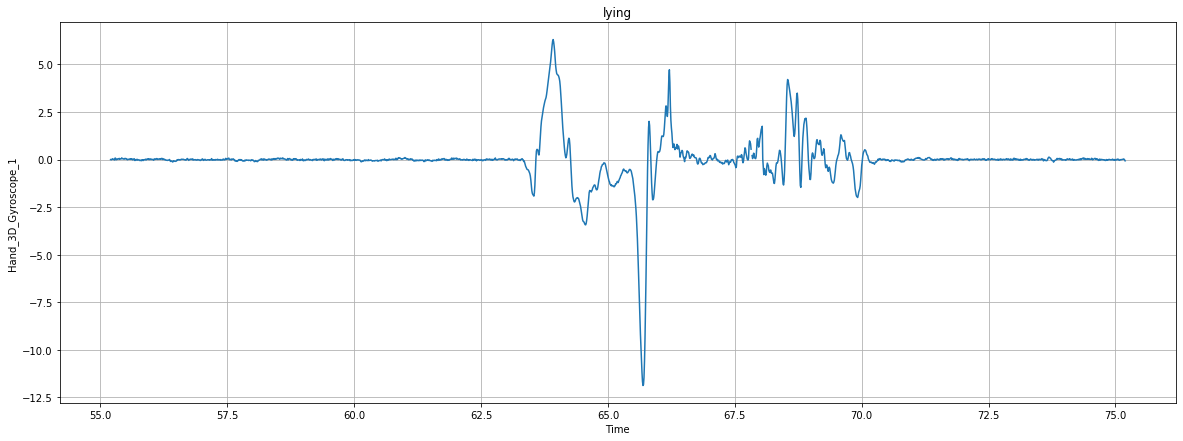

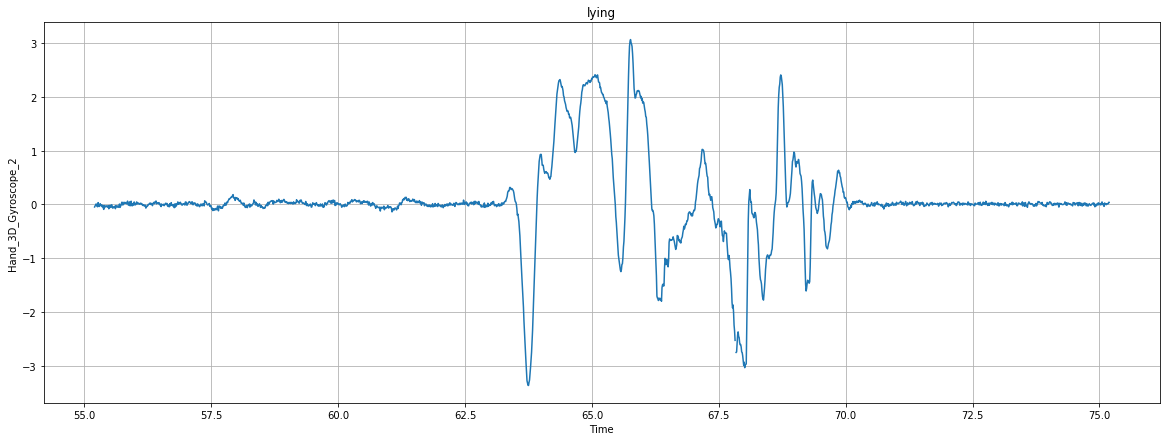

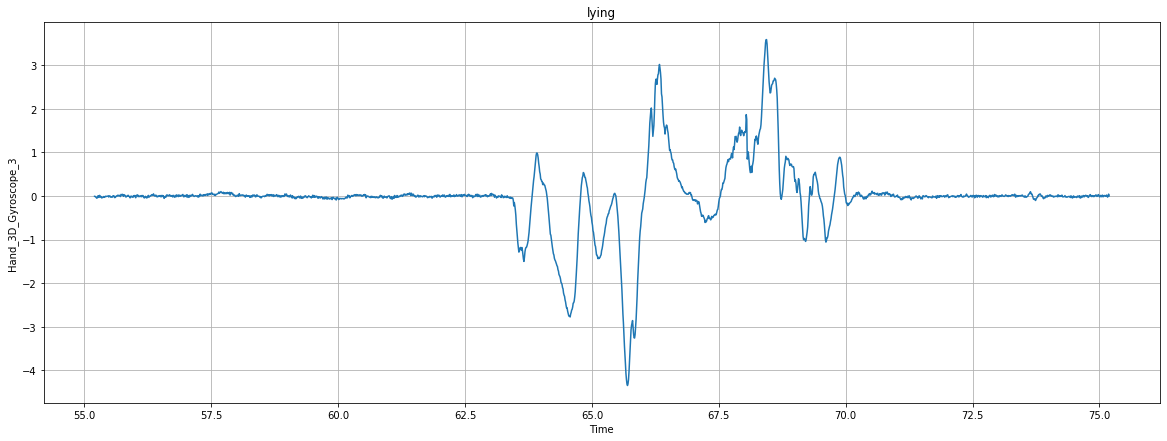

In [28]:
print_sensor_graphs(df_102, 'lying', ['Hand_3D_Gyroscope_1', 'Hand_3D_Gyroscope_2', 'Hand_3D_Gyroscope_3'], 2000, (20, 7))

In [29]:
def getValue(df, column, row):
    return df.select(column).collect()[row].asDict()[column]



col_to_drop = [
              # Hand
             
             'Hand_3D_Acceleration_4', 'Hand_3D_Acceleration_5', 'Hand_3D_Acceleration_6', 'Hand_3D_Magnetometer_1', 'Hand_3D_Magnetometer_2', 
             'Hand_3D_Magnetometer_3', 'Hand_3D_Orientation_1', 'Hand_3D_Orientation_2', 'Hand_3D_Orientation_3',
             'Hand_3D_Orientation_4',
             # Chest
             
             'Chest_3D_Acceleration_4', 'Chest_3D_Acceleration_5', 'Chest_3D_Acceleration_6',  'Chest_3D_Magnetometer_1', 'Chest_3D_Magnetometer_2', 
             'Chest_3D_Magnetometer_3', 'Chest_3D_Orientation_1', 'Chest_3D_Orientation_2', 'Chest_3D_Orientation_3',
             'Chest_3D_Orientation_4',
             # Ankle
             
             'Ankle_3D_Acceleration_4', 'Ankle_3D_Acceleration_5', 'Ankle_3D_Acceleration_6',  'Ankle_3D_Magnetometer_1', 'Ankle_3D_Magnetometer_2', 
             'Ankle_3D_Magnetometer_3', 'Ankle_3D_Orientation_1','Ankle_3D_Orientation_2', 'Ankle_3D_Orientation_3',
             'Ankle_3D_Orientation_4']

col_names2 = ['Time_stamp', 'Activity_ID', 'Heart_Rate', 
              # Hand
             'Hand_temperature',
              'Hand_3D_Acceleration_1', 'Hand_3D_Acceleration_2', 'Hand_3D_Acceleration_3',
              'Hand_3D_Gyroscope_1', 'Hand_3D_Gyroscope_2', 'Hand_3D_Gyroscope_3', 
             # Chest
             'Chest_temperature',
              'Chest_3D_Acceleration_1', 'Chest_3D_Acceleration_2', 'Chest_3D_Acceleration_3',
              'Chest_3D_Gyroscope_1', 'Chest_3D_Gyroscope_2', 'Chest_3D_Gyroscope_3',
             # Ankle
             'Ankle_temperature', 
             'Ankle_3D_Acceleration_1', 'Ankle_3D_Acceleration_2', 'Ankle_3D_Acceleration_3',
             'Ankle_3D_Gyroscope_1','Ankle_3D_Gyroscope_2', 'Ankle_3D_Gyroscope_3', ]



df = df_102


# print_sensor_graphs(df_102, 'running', ['Hand_3D_Gyroscope_1', 'Hand_3D_Gyroscope_2', 'Hand_3D_Gyroscope_3'], 2000, (20, 7))

'''
dfs = []
for activity in get_available_activities(df):
    tmp_df = df.filter(df.Activity_ID == activity_name_val[activity]) # Get only selected activity

    
    tmp_df = tmp_df.filter(tmp_df.Time_stamp > getValue(tmp_df, 'Time_stamp', 0) + 10.0) # Drop first 10 sec
    tmp_df = tmp_df.filter(tmp_df.Time_stamp < getValue(tmp_df, 'Time_stamp', tmp_df.count() - 1) - 10.0) # Drop last 10 sec
    dfs.append(tmp_df)
'''
    

#print_sensor_graphs(df, 'lying', ['Hand_3D_Gyroscope_1', 'Hand_3D_Gyroscope_2', 'Hand_3D_Gyroscope_3'], 2000, (20, 7))
#print_sensor_graphs(df, 'running', ['Hand_3D_Gyroscope_1', 'Hand_3D_Gyroscope_2', 'Hand_3D_Gyroscope_3'], 2000, (20, 7))
#print_sensor_graphs(df, 'sitting', ['Hand_3D_Gyroscope_1', 'Hand_3D_Gyroscope_2', 'Hand_3D_Gyroscope_3'], 2000, (20, 7))
#print_sensor_graphs(df, 'standing', ['Hand_3D_Gyroscope_1', 'Hand_3D_Gyroscope_2', 'Hand_3D_Gyroscope_3'], 2000, (20, 7))






"\ndfs = []\nfor activity in get_available_activities(df):\n    tmp_df = df.filter(df.Activity_ID == activity_name_val[activity]) # Get only selected activity\n\n    \n    tmp_df = tmp_df.filter(tmp_df.Time_stamp > getValue(tmp_df, 'Time_stamp', 0) + 10.0) # Drop first 10 sec\n    tmp_df = tmp_df.filter(tmp_df.Time_stamp < getValue(tmp_df, 'Time_stamp', tmp_df.count() - 1) - 10.0) # Drop last 10 sec\n    dfs.append(tmp_df)\n"

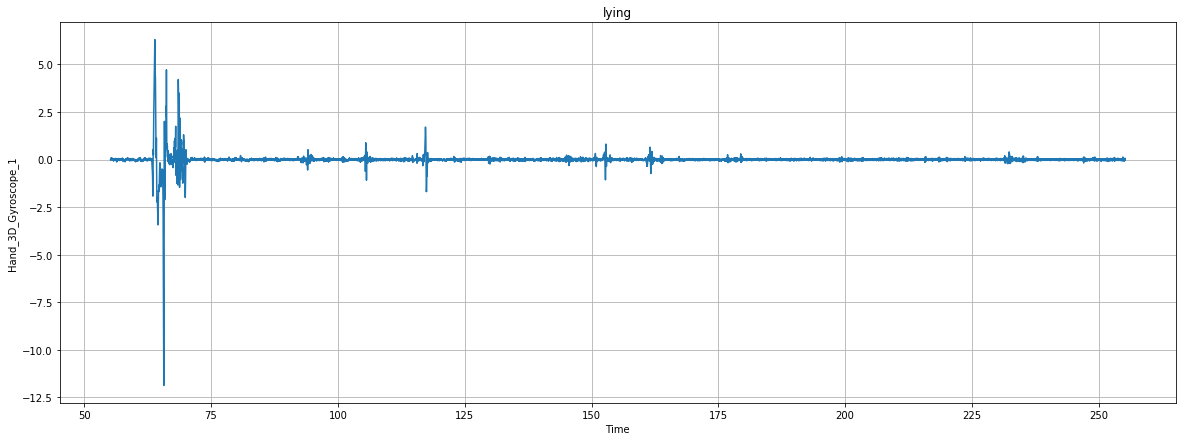

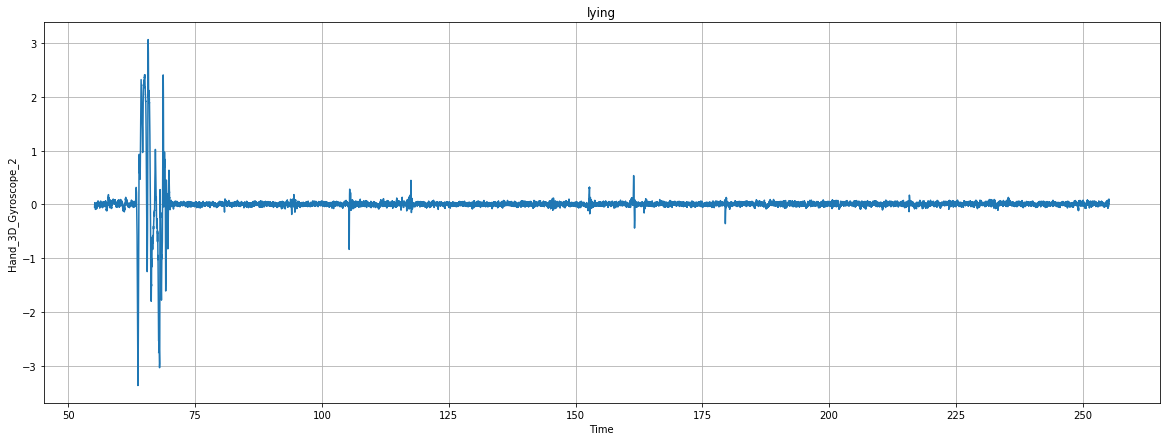

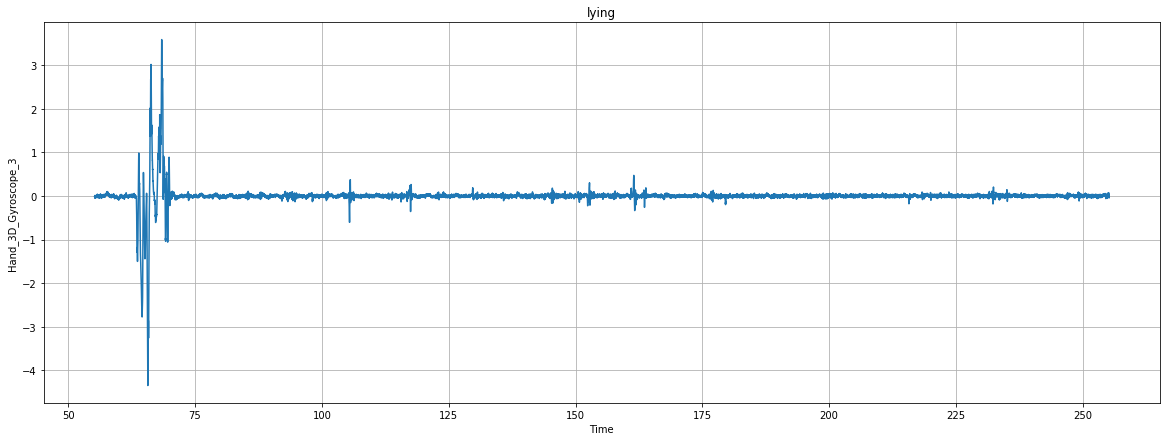

In [30]:
print_sensor_graphs(df_102, 'lying', ['Hand_3D_Gyroscope_1', 'Hand_3D_Gyroscope_2', 'Hand_3D_Gyroscope_3'], 20000, (20, 7))

The graphs show that a series of gaps in the values of the gyroscope can be filled using the nearest values, in which there are no gaps.

In [31]:
from pyspark.sql import functions as F
from pyspark.sql.functions import lit
from pyspark.sql import Window
from pyspark.sql.functions import last
import sys

from pyspark.sql.functions import col, count, isnan, lit, sum
from pyspark.sql.window import Window as W
from pyspark.sql import functions as F

df.printSchema()

df = df.withColumn('intensity', lit(0))

columns = df.columns
for column in columns:
    df = df.withColumn(column,F.when(F.isnan(F.col(column)),None).otherwise(F.col(column)))


window = Window.partitionBy('Activity_ID')\
               .orderBy('Time_stamp')\
               .rowsBetween(-sys.maxsize, 0)

# define the forward-filled column
filled_column = last(df['Heart_Rate'], ignorenulls=True).over(window)

# do the fill
df = df.withColumn('Heart_Rate', filled_column)

# show off our glorious achievements
# df.orderBy('Time_stamp', 'Activity_ID').show(4)  


df = df.where(col('Heart_Rate').isNotNull())

df = df.filter(df['Activity_ID'] != 0)

df.orderBy('Time_stamp', 'Activity_ID').show(4)  

checkpoint_1 = df
# unique(df, 'Heart_Rate')

root
 |-- Time_stamp: float (nullable = true)
 |-- Activity_ID: integer (nullable = true)
 |-- Heart_Rate: float (nullable = true)
 |-- Hand_temperature: float (nullable = true)
 |-- Hand_3D_Acceleration_1: float (nullable = true)
 |-- Hand_3D_Acceleration_2: float (nullable = true)
 |-- Hand_3D_Acceleration_3: float (nullable = true)
 |-- Hand_3D_Acceleration_4: float (nullable = true)
 |-- Hand_3D_Acceleration_5: float (nullable = true)
 |-- Hand_3D_Acceleration_6: float (nullable = true)
 |-- Hand_3D_Gyroscope_1: float (nullable = true)
 |-- Hand_3D_Gyroscope_2: float (nullable = true)
 |-- Hand_3D_Gyroscope_3: float (nullable = true)
 |-- Hand_3D_Magnetometer_1: float (nullable = true)
 |-- Hand_3D_Magnetometer_2: float (nullable = true)
 |-- Hand_3D_Magnetometer_3: float (nullable = true)
 |-- Chest_temperature: float (nullable = true)
 |-- Chest_3D_Acceleration_1: float (nullable = true)
 |-- Chest_3D_Acceleration_2: float (nullable = true)
 |-- Chest_3D_Acceleration_3: float (nu

In [32]:
unique(df, 'Activity_ID')
shape(df)

+-----------+
|Activity_ID|
+-----------+
|          1|
|          2|
|          3|
|          4|
|          5|
|          6|
|          7|
|         12|
|         13|
|         16|
|         17|
|         24|
+-----------+

(263294, 43)


In [33]:
df.printSchema()


target_labels = ['minimum','low','medium','high']
conversion_dict = {'minimum':[1,2,3,9,10,11,18],
                   'low': [17,13,19],
                   'medium': [4,12,16],
                   'high':[5,6,7,20,24]}


df = checkpoint_1
final_df = 0






for tl in target_labels:
    lact = conversion_dict[tl]
    for iactivity in lact:
        df = df.withColumn('intensity', F.when(F.col('Activity_ID') == iactivity, tl).otherwise(F.col("intensity")))





'''
for tl in target_labels:
    lact = conversion_dict[tl]
    for iactivity in lact:
        tmp_df = df.filter(df['Activity_ID'] == iactivity).withColumn('intensity', F.when(F.col('intensity')==0, tl).otherwise(F.col("intensity")))
        
        if final_df == 0:
            final_df = tmp_df
        else:
            final_df = final_df.union(tmp_df)
'''

# df.select('intensity')
unique(df, 'intensity')
unique(df, 'Activity_ID')
shape(df)


final_df = df

root
 |-- Time_stamp: float (nullable = true)
 |-- Activity_ID: integer (nullable = true)
 |-- Heart_Rate: float (nullable = true)
 |-- Hand_temperature: float (nullable = true)
 |-- Hand_3D_Acceleration_1: float (nullable = true)
 |-- Hand_3D_Acceleration_2: float (nullable = true)
 |-- Hand_3D_Acceleration_3: float (nullable = true)
 |-- Hand_3D_Acceleration_4: float (nullable = true)
 |-- Hand_3D_Acceleration_5: float (nullable = true)
 |-- Hand_3D_Acceleration_6: float (nullable = true)
 |-- Hand_3D_Gyroscope_1: float (nullable = true)
 |-- Hand_3D_Gyroscope_2: float (nullable = true)
 |-- Hand_3D_Gyroscope_3: float (nullable = true)
 |-- Hand_3D_Magnetometer_1: float (nullable = true)
 |-- Hand_3D_Magnetometer_2: float (nullable = true)
 |-- Hand_3D_Magnetometer_3: float (nullable = true)
 |-- Chest_temperature: float (nullable = true)
 |-- Chest_3D_Acceleration_1: float (nullable = true)
 |-- Chest_3D_Acceleration_2: float (nullable = true)
 |-- Chest_3D_Acceleration_3: float (nu

In [34]:
print(type(final_df))
df = final_df

def intensityStrToInt(val_str):
    return ['minimum','low','medium','high'].index(val_str)

def getStrList(df, column, limit=0):
    selected_df = df.select(column)
    if limit != 0:
        selected_df = selected_df.limit(limit)
    
    return [row[column] for row in selected_df.collect()]



df = df.withColumn('Hand_Accelerator_norm', (col('Hand_3D_Acceleration_1') ** 2 + \
                                             col('Hand_3D_Acceleration_2') ** 2 + \
                                             col('Hand_3D_Acceleration_3') ** 2) ** 0.5)
df = df.withColumn('Hand_Gyroscope_norm',   (col('Hand_3D_Gyroscope_1') ** 2 + \
                                             col('Hand_3D_Gyroscope_2') ** 2 + \
                                             col('Hand_3D_Gyroscope_3') ** 2) ** 0.5)


labels = ['minimum','low','medium','high']

# Prepare the array of labels for the machine learning data set
intesity_labels = getStrList(df, 'intensity')
target_labels = np.array([labels.index(x) for x in intesity_labels])




col_names_with_features = [
        
             'Time_stamp',  'Heart_Rate', 
              # Hand
             'Hand_temperature',
             'Hand_3D_Acceleration_1', 'Hand_3D_Acceleration_2', 'Hand_3D_Acceleration_3',
             'Hand_3D_Gyroscope_1', 'Hand_3D_Gyroscope_2', 'Hand_3D_Gyroscope_3', 
             'Hand_Accelerator_norm', 
             'Hand_Gyroscope_norm',
             # Chest
             #'Chest_temperature',
             #'Chest_3D_Acceleration_1', 'Chest_3D_Acceleration_2', 'Chest_3D_Acceleration_3',
             #'Chest_3D_Gyroscope_1', 'Chest_3D_Gyroscope_2', 'Chest_3D_Gyroscope_3',
             # Ankle
             #'Ankle_temperature', 
             #'Ankle_3D_Acceleration_1', 'Ankle_3D_Acceleration_2', 'Ankle_3D_Acceleration_3',
             #'Ankle_3D_Gyroscope_1','Ankle_3D_Gyroscope_2', 'Ankle_3D_Gyroscope_3',
             ]



              
# Prepare the array of target features for the machine learning data set
dd = df[col_names_with_features].collect()
target_features = np.array(dd)

<class 'pyspark.sql.dataframe.DataFrame'>


In [35]:
data_to_RF = df[col_names_with_features]

target_features = np.array(dd)
print(dd[0])
print(target_features[1])

Row(Time_stamp=1734.1700439453125, Heart_Rate=92.0, Hand_temperature=34.375, Hand_3D_Acceleration_1=-8.77245044708252, Hand_3D_Acceleration_2=2.5706400871276855, Hand_3D_Acceleration_3=2.517159938812256, Hand_3D_Gyroscope_1=0.17301499843597412, Hand_3D_Gyroscope_2=0.02338930033147335, Hand_3D_Gyroscope_3=-0.03267810121178627, Hand_Accelerator_norm=9.481570094748415, Hand_Gyroscope_norm=0.1776206839098525)
[1734.1800537109375 92.0 34.375 -8.666830062866211 2.6057000160217285
 2.2876999378204346 0.20332400500774384 0.03760790079832077
 -0.021796099841594696 9.334730147015541 0.2079184339666643]


In [36]:

def get_available_activities(df):
    activities = getList(getUnique(df, 'Activity_ID', True), 'Activity_ID')
    for i in range(len(activities)):
        activities[i] = int(activities[i])

    res = []
    for act in activities:
        res.append(activity_val_name[act])
    return res

'''
print(type(data_to_RF))

final_df2 = 0
for activity in ['running', 'walking']:# get_available_activities(data_to_RF):

    tmp_df = data_to_RF.filter(data_to_RF.Activity_ID == activity_name_val[activity]) # Get only selected activity


    start = getValue(tmp_df, 'Time_stamp', 0)
    end = getValue(tmp_df, 'Time_stamp', tmp_df.count() - 1)
    
    print('CP_0_3')
    
    top_limit = (end - 10.0) - (end - start) * 0.2
    
    print('CP_1')
    
    tmp_df = tmp_df.filter(tmp_df.Time_stamp > start + 10.0) # Drop first 10 sec
    print('CP_2')
    tmp_df = tmp_df.filter(tmp_df.Time_stamp < top_limit) # Drop last 10 sec
    print('CP_3')

    if final_df2 == 0:
        final_df2 = tmp_df
    else:
        final_df2 = final_df2.union(tmp_df)
    
    print('CP_4')
'''

"\nprint(type(data_to_RF))\n\nfinal_df2 = 0\nfor activity in ['running', 'walking']:# get_available_activities(data_to_RF):\n\n    tmp_df = data_to_RF.filter(data_to_RF.Activity_ID == activity_name_val[activity]) # Get only selected activity\n\n\n    start = getValue(tmp_df, 'Time_stamp', 0)\n    end = getValue(tmp_df, 'Time_stamp', tmp_df.count() - 1)\n    \n    print('CP_0_3')\n    \n    top_limit = (end - 10.0) - (end - start) * 0.2\n    \n    print('CP_1')\n    \n    tmp_df = tmp_df.filter(tmp_df.Time_stamp > start + 10.0) # Drop first 10 sec\n    print('CP_2')\n    tmp_df = tmp_df.filter(tmp_df.Time_stamp < top_limit) # Drop last 10 sec\n    print('CP_3')\n\n    if final_df2 == 0:\n        final_df2 = tmp_df\n    else:\n        final_df2 = final_df2.union(tmp_df)\n    \n    print('CP_4')\n"

In [37]:
final_df2 = df

final_df2.printSchema()

final_df2.show()

data_nan_dropped = final_df2.dropna()
final_df2 = data_nan_dropped
print(data_nan_dropped.count())

root
 |-- Time_stamp: float (nullable = true)
 |-- Activity_ID: integer (nullable = true)
 |-- Heart_Rate: float (nullable = true)
 |-- Hand_temperature: float (nullable = true)
 |-- Hand_3D_Acceleration_1: float (nullable = true)
 |-- Hand_3D_Acceleration_2: float (nullable = true)
 |-- Hand_3D_Acceleration_3: float (nullable = true)
 |-- Hand_3D_Acceleration_4: float (nullable = true)
 |-- Hand_3D_Acceleration_5: float (nullable = true)
 |-- Hand_3D_Acceleration_6: float (nullable = true)
 |-- Hand_3D_Gyroscope_1: float (nullable = true)
 |-- Hand_3D_Gyroscope_2: float (nullable = true)
 |-- Hand_3D_Gyroscope_3: float (nullable = true)
 |-- Hand_3D_Magnetometer_1: float (nullable = true)
 |-- Hand_3D_Magnetometer_2: float (nullable = true)
 |-- Hand_3D_Magnetometer_3: float (nullable = true)
 |-- Chest_temperature: float (nullable = true)
 |-- Chest_3D_Acceleration_1: float (nullable = true)
 |-- Chest_3D_Acceleration_2: float (nullable = true)
 |-- Chest_3D_Acceleration_3: float (nu

259073


In [38]:
df2 = final_df2
# shape(df2)
#print(df2.count())

df2 = df2.drop('Time_stamp', 'Activity_ID', 'Hand_3D_Acceleration_4', 'Hand_3D_Acceleration_5', 'Hand_3D_Acceleration_6', 'Hand_3D_Magnetometer_1', 'Hand_3D_Magnetometer_2', 'Hand_3D_Magnetometer_3', 'Chest_temperature', 'Chest_3D_Acceleration_1', 'Chest_3D_Acceleration_2', 'Chest_3D_Acceleration_3', 'Chest_3D_Acceleration_4', 'Chest_3D_Acceleration_5', 'Chest_3D_Acceleration_6', 'Chest_3D_Gyroscope_1', 'Chest_3D_Gyroscope_2', 'Chest_3D_Gyroscope_3', 'Chest_3D_Magnetometer_1', 'Chest_3D_Magnetometer_2', 'Chest_3D_Magnetometer_3', 'Ankle_temperature', 'Ankle_3D_Acceleration_1', 'Ankle_3D_Acceleration_2', 'Ankle_3D_Acceleration_3', 'Ankle_3D_Acceleration_4', 'Ankle_3D_Acceleration_5', 'Ankle_3D_Acceleration_6', 'Ankle_3D_Gyroscope_1', 'Ankle_3D_Gyroscope_2', 'Ankle_3D_Gyroscope_3', 'Ankle_3D_Magnetometer_1', 'Ankle_3D_Magnetometer_2', 'Ankle_3D_Magnetometer_3')
df2.show(1)

col_names_with_features = [
        
              "Heart_Rate", 
              # Hand
             'Hand_temperature',
             'Hand_3D_Acceleration_1', 'Hand_3D_Acceleration_2', 'Hand_3D_Acceleration_3',
             'Hand_3D_Gyroscope_1', 'Hand_3D_Gyroscope_2', 'Hand_3D_Gyroscope_3', 
             'Hand_Accelerator_norm', 
             'Hand_Gyroscope_norm',

             # Chest
             #'Chest_temperature',
             #'Chest_3D_Acceleration_1', 'Chest_3D_Acceleration_2', 'Chest_3D_Acceleration_3',
             #'Chest_3D_Gyroscope_1', 'Chest_3D_Gyroscope_2', 'Chest_3D_Gyroscope_3',
             # Ankle
             #'Ankle_temperature', 
             #'Ankle_3D_Acceleration_1', 'Ankle_3D_Acceleration_2', 'Ankle_3D_Acceleration_3',
             #'Ankle_3D_Gyroscope_1','Ankle_3D_Gyroscope_2', 'Ankle_3D_Gyroscope_3',
             ]


from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

vector_assembler = VectorAssembler(\
inputCols=col_names_with_features,\
outputCol="features")
df_temp = vector_assembler.transform(df2)

df_temp = df_temp.drop("Heart_Rate", "Hand_temperature",  "Hand_3D_Acceleration_1", "Hand_3D_Acceleration_2", "Hand_3D_Acceleration_3", "Hand_3D_Gyroscope_1", "Hand_3D_Gyroscope_2", "Hand_3D_Gyroscope_3", "Hand_Accelerator_norm", "Hand_Gyroscope_norm")


from pyspark.ml.feature import StringIndexer





l_indexer = StringIndexer(inputCol="intensity", outputCol="labelIndex")

df_temp = l_indexer.fit(df_temp).transform(df_temp)
df_temp.show(1)

+----------+----------------+----------------------+----------------------+----------------------+-------------------+-------------------+-------------------+---------+---------------------+-------------------+
|Heart_Rate|Hand_temperature|Hand_3D_Acceleration_1|Hand_3D_Acceleration_2|Hand_3D_Acceleration_3|Hand_3D_Gyroscope_1|Hand_3D_Gyroscope_2|Hand_3D_Gyroscope_3|intensity|Hand_Accelerator_norm|Hand_Gyroscope_norm|
+----------+----------------+----------------------+----------------------+----------------------+-------------------+-------------------+-------------------+---------+---------------------+-------------------+
|      92.0|          34.375|              -8.77245|               2.57064|               2.51716|           0.173015|          0.0233893|         -0.0326781|   medium|    9.481570094748415| 0.1776206839098525|
+----------+----------------+----------------------+----------------------+----------------------+-------------------+-------------------+------------------

In [39]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

(trainingData, testData) = df_temp.randomSplit([0.7, 0.3])

dt = DecisionTreeClassifier(labelCol="labelIndex", featuresCol="features")
model = dt.fit(trainingData)

predictions = model.transform(testData)



In [40]:
predictions.select("prediction", "labelIndex").show(5)

evaluator = MulticlassClassificationEvaluator(\
    labelCol="labelIndex", predictionCol="prediction",\
    metricName="accuracy")

accuracy = evaluator.evaluate(predictions)

print(type(accuracy))
print(accuracy)
# print("Test Error = ", (1.0 — accuracy))

+----------+----------+
|prediction|labelIndex|
+----------+----------+
|       2.0|       2.0|
|       2.0|       2.0|
|       2.0|       2.0|
|       2.0|       2.0|
|       2.0|       2.0|
+----------+----------+
only showing top 5 rows

<class 'float'>
0.9454211088105557


In [ ]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint

transformed_df = data_to_RF.rdd.map(lambda row: LabeledPoint(row[-1], Vectors.dense(row[0:-1])))
TRAINING_DATA_RATIO = 0.8

splits = [TRAINING_DATA_RATIO, 1.0 - TRAINING_DATA_RATIO]
training_data, test_data = transformed_df.randomSplit(splits, 42)

print("Number of training set rows: %d" % training_data.count())
print("Number of test set rows: %d" % test_data.count())

In [ ]:
from pyspark.mllib.tree import RandomForest
from time import *

start_time = time()

model = RandomForest.trainClassifier(training_data, numClasses=2, categoricalFeaturesInfo={}, \
    numTrees=RF_NUM_TREES, featureSubsetStrategy="auto", impurity="gini", \
    maxDepth=RF_MAX_DEPTH, maxBins=RF_MAX_BINS, seed=RANDOM_SEED)

end_time = time()
elapsed_time = end_time - start_time
print("Time to train model: %.3f seconds" % elapsed_time)

In [ ]:
predictions = model.predict(test_data.map(lambda x: x.features))
labels_and_predictions = test_data.map(lambda x: x.label).zip(predictions)
acc = labels_and_predictions.filter(lambda x: x[0] == x[1]).count() / float(test_data.count())
print("Model accuracy: %.3f%%" % (acc * 100))

In [ ]:
from pyspark.sql.functions import col, count, isnan, lit, sum
from pyspark.sql.window import Window as W
from pyspark.sql import functions as F

def count_not_null(c, nan_as_null=False):
    pred = col(c).isNotNull() & (~isnan(c) if nan_as_null else lit(True))
    return sum(pred.cast("integer")).alias(c)
# df.agg(*[count_not_null(c) for c in df.columns]).show()
    
def getValue(df, column, row):
    return df.select(column).collect()[row].asDict()[column]

def get_available_activities(df):
    activities = getList(getUnique(df, 'Activity_ID', True), 'Activity_ID')
    for i in range(len(activities)):
        activities[i] = int(activities[i])

    res = []
    for act in activities:
        res.append(activity_val_name[act])
    return res

# df_102_walk = df_102.filter(df_102.Activity_ID == activity_name_val['walking'])
# df = df_102_walk
df = df_102
DF_102_FEATURE_MAP = {}
DF_102_SPLITTED = {}


# shape(df2)
# df.printSchema()
# df2.printSchema()
# df2.select('idx').limit(10).show()

SPLIT_SIZE = 500 # Size 500 ==  5.00 secs

asd = 0
for activity in get_available_activities(df):
    tmp_df = df.filter(df.Activity_ID == activity_name_val[activity]) # Get only selected activity
    tmp_df = tmp_df.filter(tmp_df.Time_stamp > getValue(tmp_df, 'Time_stamp', 0) + 10.0) # Drop first 10 sec
    tmp_df = tmp_df.filter(tmp_df.Time_stamp < getValue(tmp_df, 'Time_stamp', tmp_df.count() - 1) - 10.0) # Drop last 10 sec
    tmp_df = tmp_df.withColumn('id', F.monotonically_increasing_id())
    
    # Fill feature array
    DF_102_SPLITTED[activity] = []
    for i in range(round(tmp_df.count() / SPLIT_SIZE)):
        to_add = tmp_df.filter(tmp_df['id'] >= i * SPLIT_SIZE).filter(tmp_df['id'] < (i + 1) * SPLIT_SIZE)
        
        DF_102_SPLITTED[activity].append(to_add)
        
        to_add.limit(1).show()
    
        if asd == 1:
            break
        else:
            asd += 1
    break
    

# prepare features
for activity in DF_102_SPLITTED:

    
    rows = []
    for i in range(len(DF_102_SPLITTED[activity])):
        new_row = []
        
        tmp_df = DF_102_SPLITTED[activity][i]
    
    
        columns = tmp_df.columns
        columns.remove('Time_stamp')
        columns.remove('Activity_ID')
        columns.remove('Heart_Rate')
        columns.remove('id')
        for column in columns:
            new_row.append(np.mean(tmp_df[column]))
            new_row.append(np.std(tmp_df[column]))
        
        
        
    
    
    

# DF_102_SPLITTED[next(iter(DF_102_SPLITTED))][0].limit(3).show()

In [ ]:
from pyspark.sql.functions import col, avg
from pyspark.sql.functions import isnan, when, count, col

df.limit(7000).select([count(when(isnan(c), c)).alias(c) for c in ['Hand_3D_Gyroscope_1']]).show()




def diff(a):
    return [a[ii+1]-a[ii] for ii in range(a.__len__()-1)]

function = udf(lambda c: diff(c))
df.withColumn("col_new",function(col("col"))).show(20,False)



print('isnan: ', np.isnan(getList(df_102, 'Hand_3D_Gyroscope_1', 7000)).any())

print(np.mean(getList(df_102, 'Hand_3D_Gyroscope_1', 7000)))

print(df_102.filter(df_102.Activity_ID == 4).agg(avg(col('Hand_3D_Gyroscope_1'))))

In [ ]:

x = np.arange(10)



asd = df_102
asd.limit(10).withColumn('Time_stamp', x).select('Time_stamp').show()

In [ ]:
from pyspark.sql.types import *
cSchema = StructType([StructField('Time_stamp', ArrayType(StringType()))])

# notice extra square brackets around each element of list 
test_list = [['Hello', 'world']], [['I', 'am', 'fine']]

asd = spark.createDataFrame(test_list,schema=cSchema)
print(type(test_list))
print(test_list)


from pyspark.sql.types import *
cSchema = StructType([StructField('Time_stamp', IntegerType())])

# notice extra square brackets around each element of list 

# test_list = tuple(np.arange(10))
# test_list = [1], [2]

test_list = []
for i in range(10):
    test_list.append([i])




print(type(test_list))
print(test_list)

asd = spark.createDataFrame(test_list,schema=cSchema)


asd.show()
asd.printSchema()


print(type(asd.select('Time_stamp').collect()))


asd = df_102
asd.limit(10).withColumn('Time_stamp', asd.select('Time_stamp')).select('Time_stamp').show()



In [ ]:
import pandas as pd 
  
# initialize list of lists 
data = [[1, 2, 3, 4], [2, 3, 4, 5],[3, 4, 5, 6] ] 
  
# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['f1', 'f2', 'f3', 'f4']) 

print(df)

print()

df.loc[:,'f_norm']=df[['f1', 'f2']].apply(lambda x: np.linalg.norm(x), axis=1)

print(df)

In [ ]:
from pyspark.sql.types import IntegerType
asd = spark.createDataFrame([10,11,13], IntegerType()).toDF("col1")
# asd.show()

asd = asd.withColumn('col2', col("col1"))
asd = asd.withColumn('col3', col("col1") ** 2)
asd = asd.withColumn('col4', col("col1") ** 0.5)


asd.show()



In [ ]:
pd_df =  pd.load('PAMAP2_Dataset\Protocol\subject102.dat')